### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
os.path.dirname(os.path.abspath('__file__'))
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import math
import random

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
## Import_Local
from Src_Dev_Common import DEV_Common_Data_Datetime as com_date
from Src_Dev_Common import DEV_KASI_Holiday as com_Holi
from Src_Dev_Common import DEV_Common_Data_Analysis as com_Analysis
from Src_Dev_Common import DEV_Common_Data_Preprocessing as com_Prep
from Src_Dev_Common import DEV_Common_Data_Visualization as com_Visual
from Src_Dev_Common import DEV_KMA_Weather_ASOS as com_ASOS
from Src_Dev_Common import DEV_KDHC_Usage as com_KDHC

### 01-01-02. Config (Directory, Params)

In [4]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [5]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-01-02 10:30:27.548008
2024 / 1 / 2
10 : 30


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [192]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', index_col = 0)
df_kdhc_heat = df_kdhc_heat[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'rest_YN', 'dist_from_holiday'
                             ,'HOUR'
                            #  , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                            #  , 'humidity'
                            #  , 'rainfall'
                            #  , 'snowfall', 'snowfall_3hr'
                            #  , 'wind_speed', 'wind_direction'
                            #  , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                            #  , 'visual_range'
                             , 'PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
                             , 'KANGNAM'
                             , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
                             , 'KIMHAE', 'DAEGU', 'YANGSAN'
                             , 'GWANGJU_JEONNAM']]
## 어디서 중복 생긴건지 확인 필요
df_kdhc_heat = df_kdhc_heat.drop_duplicates()
# print(df_kdhc_heat.columns)
# df_kdhc_heat

['KDHC_COMB_HEAT-CJ_ASOS_KASI_2010-2023.csv', 'KDHC_COMB_HEATSxPCA01_2019-2022_Scaled.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_COMB_HEAT_2019-2022.csv', 'KDHC_COMB_KANGNAMHEATxWEATHER_2019-2022.csv', 'KDHC_HEAT', 'KDHC_HEAT.zip', 'KDHC_HEAT_19Region_hr.csv', 'KDHC_HEAT_CHEONGJU_2010_2021.csv', 'KDHC_HEAT_CHEONGJU_2010_2021_1st_Check.csv', 'KDHC_HEAT_SEJONG_2014_2018.csv', 'KDHC_HEAT_SEJONG_2014_2018_1st_Check.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']


In [196]:
df_kdhc_heat['METER_DATE'] = pd.to_datetime(df_kdhc_heat['METER_DATE'])

## "METER_DATE"(DATETIME)으로부터 "DATE"를 추출
# df_kdhc_heat['DATE'] = df_kdhc_heat['METER_DATE'].dt.strftime('%Y-%m-%d') 

## 추출된 "DATE"로부터 Week를 계산
df_kdhc_heat['WEEK'] = df_kdhc_heat['METER_DATE'].dt.strftime('%G-%V') 

# df_kdhc_heat_month = df_kdhc_heat[(df_kdhc_heat['MONTH'] == 12) & (df_kdhc_heat['DAY'] == 31)]

# df_kdhc_heat_month.head(60)

In [215]:
## 날짜 범위 추출
# df_dt = pd.DataFrame()
# int_dt_start = dt.datetime(2020, 1, 1, 0, 0, 0)
# int_dt_end = dt.datetime(2020, 12, 31, 23, 0, 0)
# df_dt = create_df_dt(df_dt, "METER_DATE", int_dt_start, int_dt_end, '1D')
# df_dt['WEEK'] = df_dt['METER_DATE'].dt.strftime('%G-%V')
# df_dt['WEEK'] = df_dt['WEEK'].astype("str")
# df_dt = df_dt[['METER_DATE', 'WEEK', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week']]
# df_dt.to_csv("dates_temp.csv")
# df_dt

▶ 
Region / WOD / Sum / Mean
PAJU  / Mon   /  453  /  18.875
PAJU  / Tue   /  409  /  17.041666666666668
PAJU  / Wed   /  307  /  12.791666666666666
PAJU  / Thr   /  395  /  16.458333333333332
PAJU  / Fri   /  383  /  15.958333333333334
PAJU  / Sat   /  449  /  18.708333333333332
PAJU  / Sun   /  449  /  18.708333333333332
▶ 
Region / WOD / Sum / Mean
GOYANG  / Mon   /  2112.0  /  88.0
GOYANG  / Tue   /  1885.0  /  78.54166666666667
GOYANG  / Wed   /  1697.0  /  70.70833333333333
GOYANG  / Thr   /  1600.0  /  66.66666666666667
GOYANG  / Fri   /  1616.0  /  67.33333333333333
GOYANG  / Sat   /  1455.0  /  60.625
GOYANG  / Sun   /  1513.0  /  63.041666666666664
▶ 
Region / WOD / Sum / Mean
KANGNAM  / Mon   /  2336.2  /  97.34166666666665
KANGNAM  / Tue   /  2309.2  /  96.21666666666665
KANGNAM  / Wed   /  2403.2  /  100.13333333333333
KANGNAM  / Thr   /  2360.2  /  98.34166666666665
KANGNAM  / Fri   /  2408.2  /  100.34166666666665
KANGNAM  / Sat   /  1828.2  /  76.175
KANGNAM  / Sun   / 

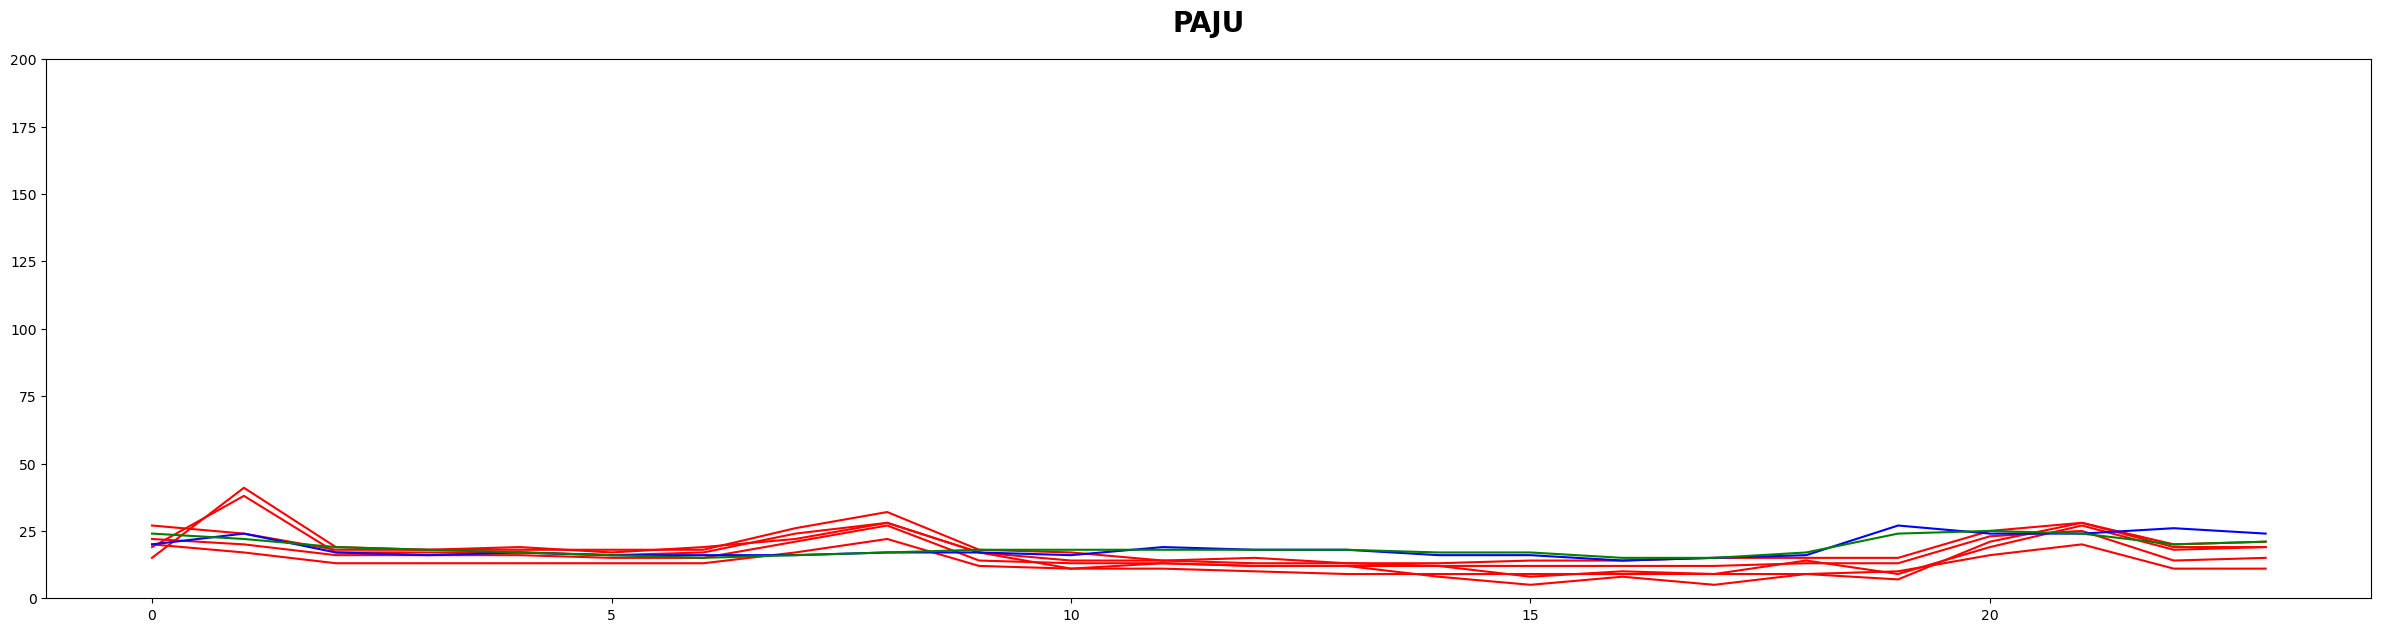

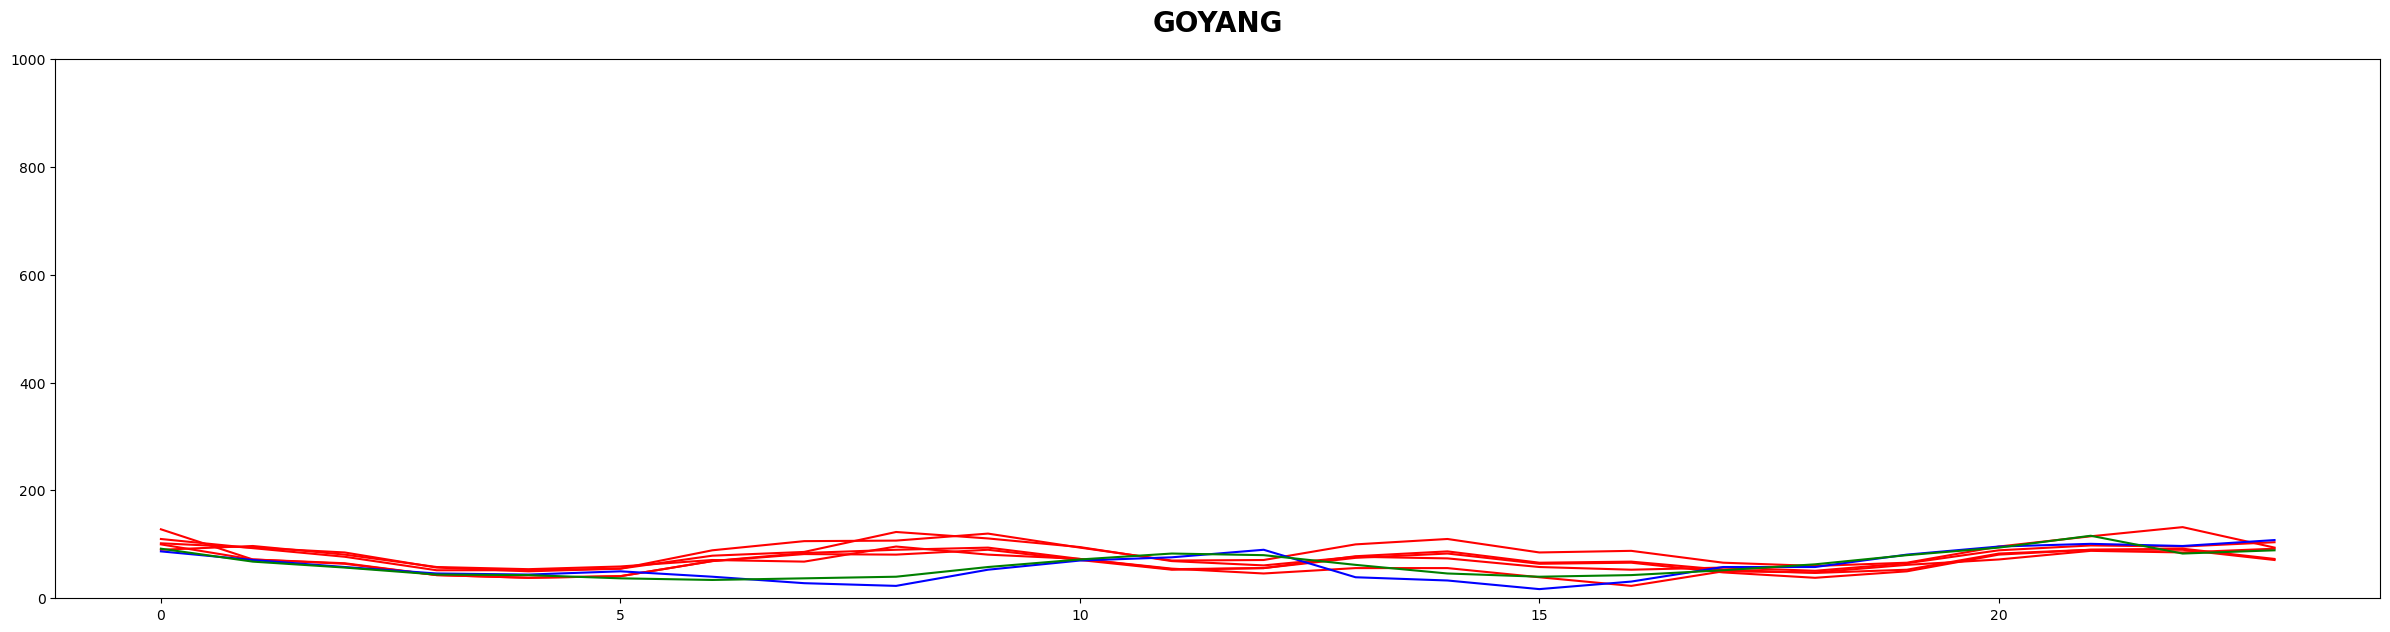

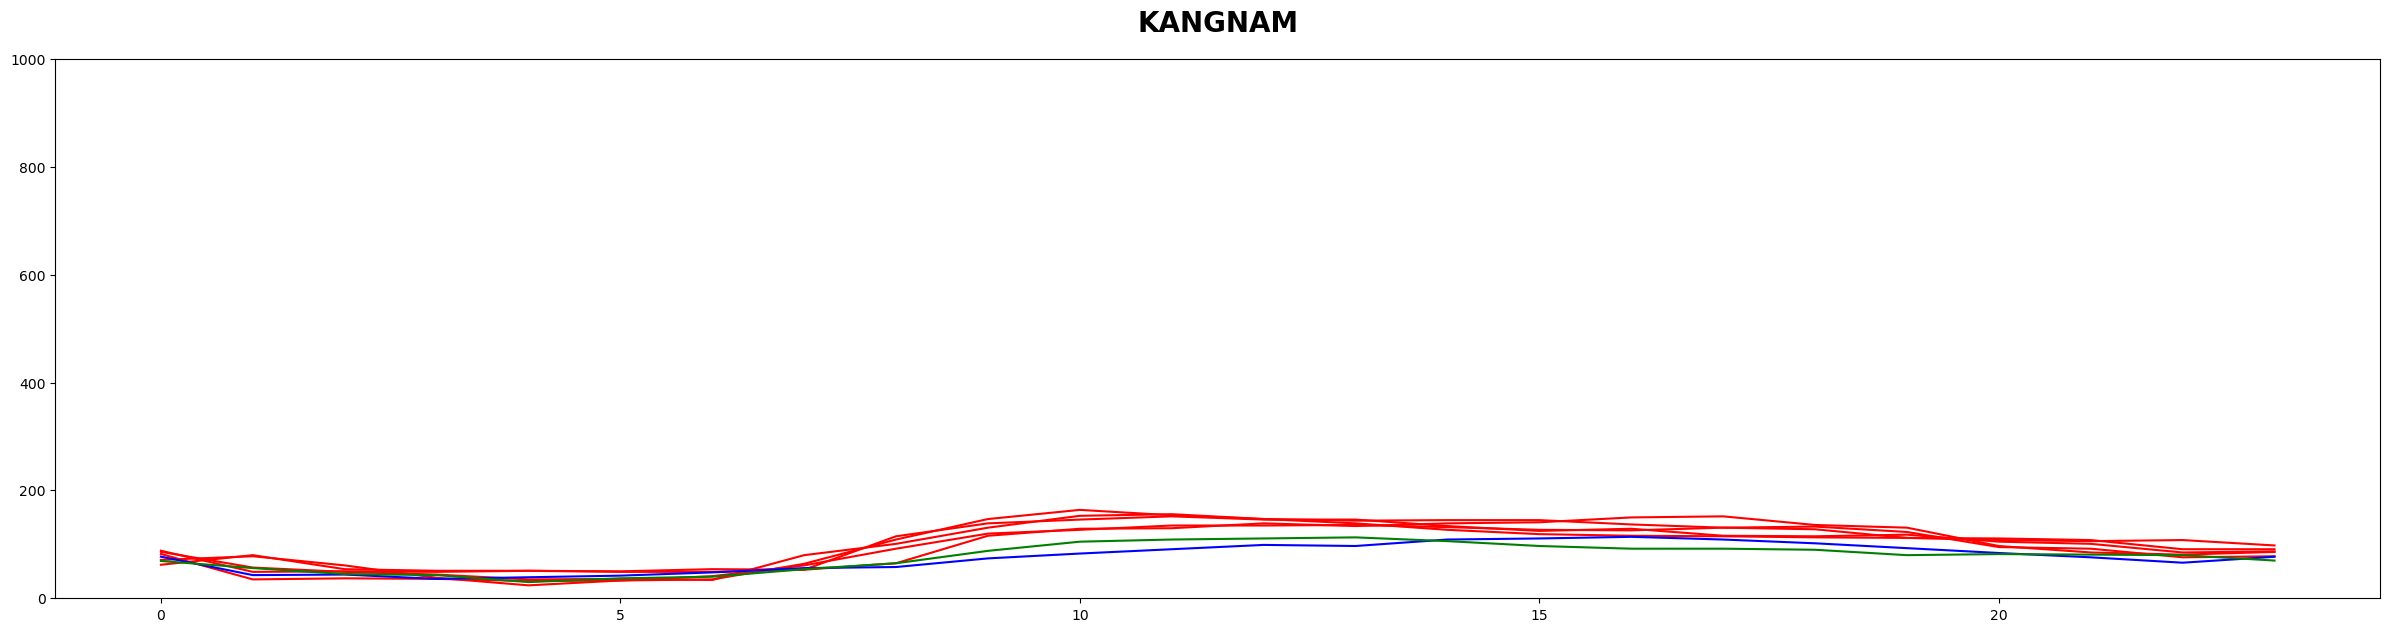

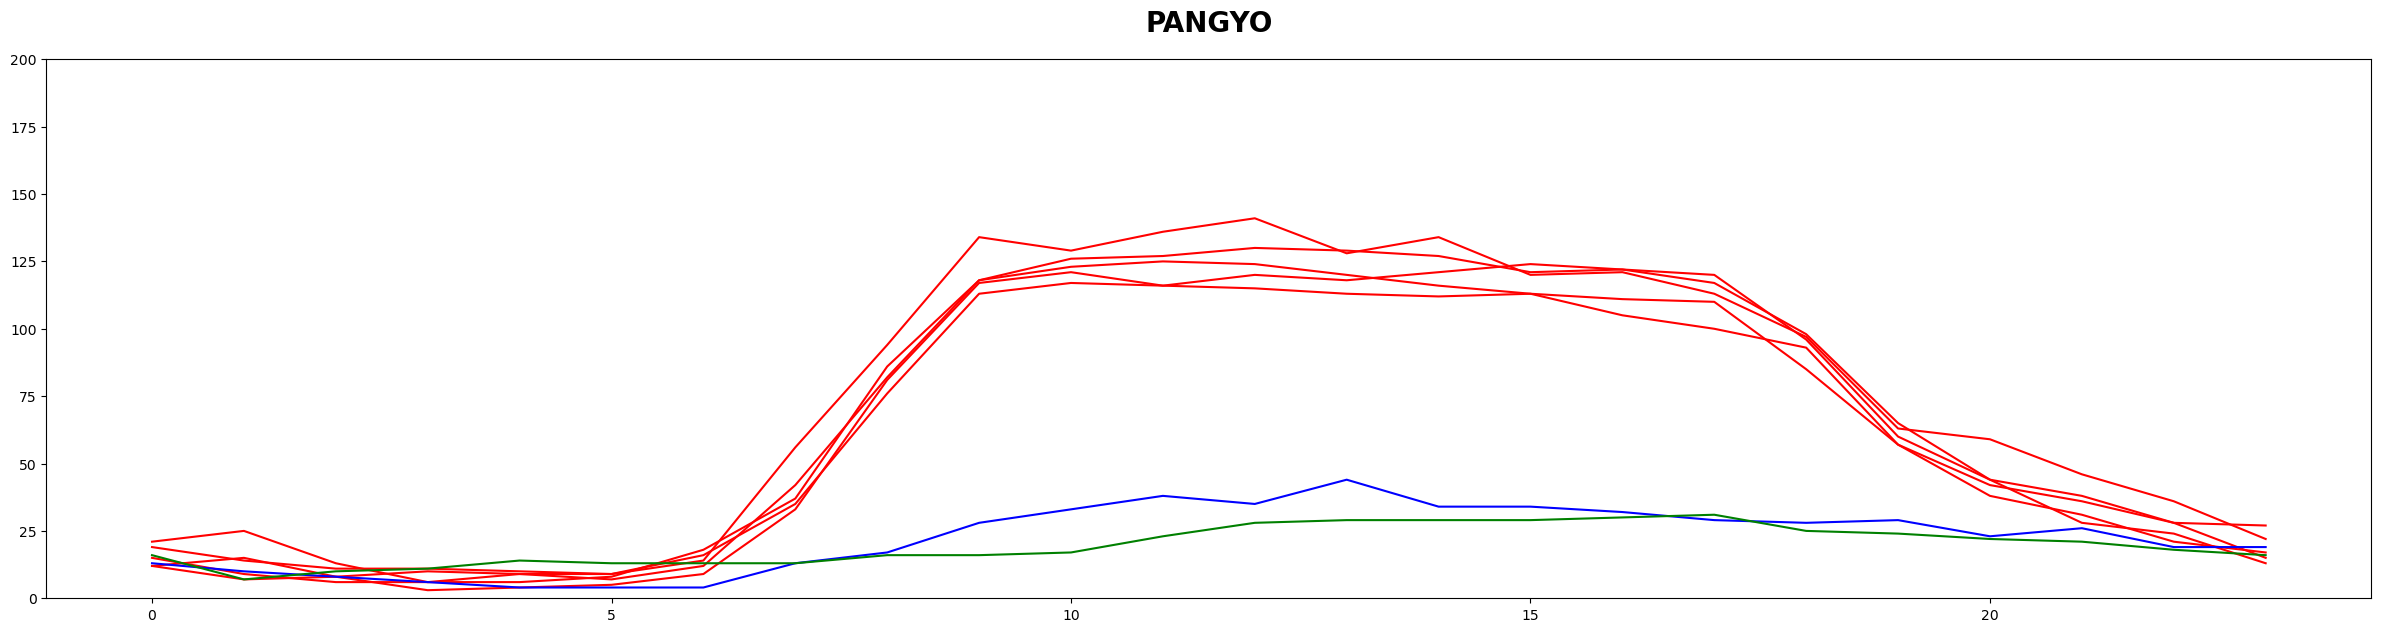

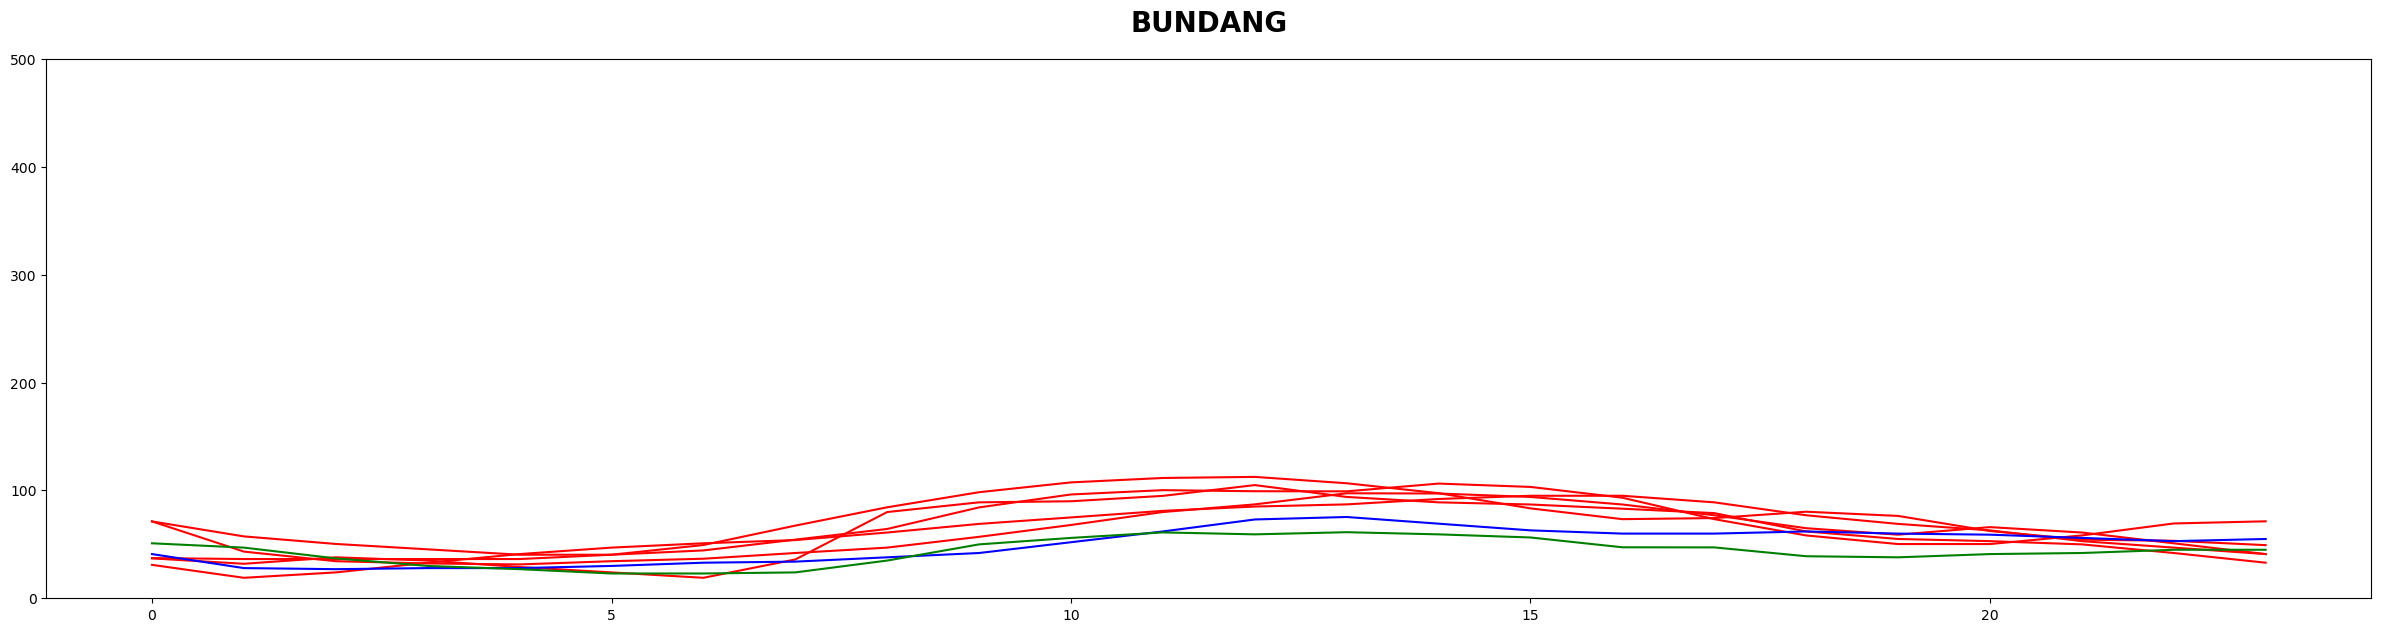

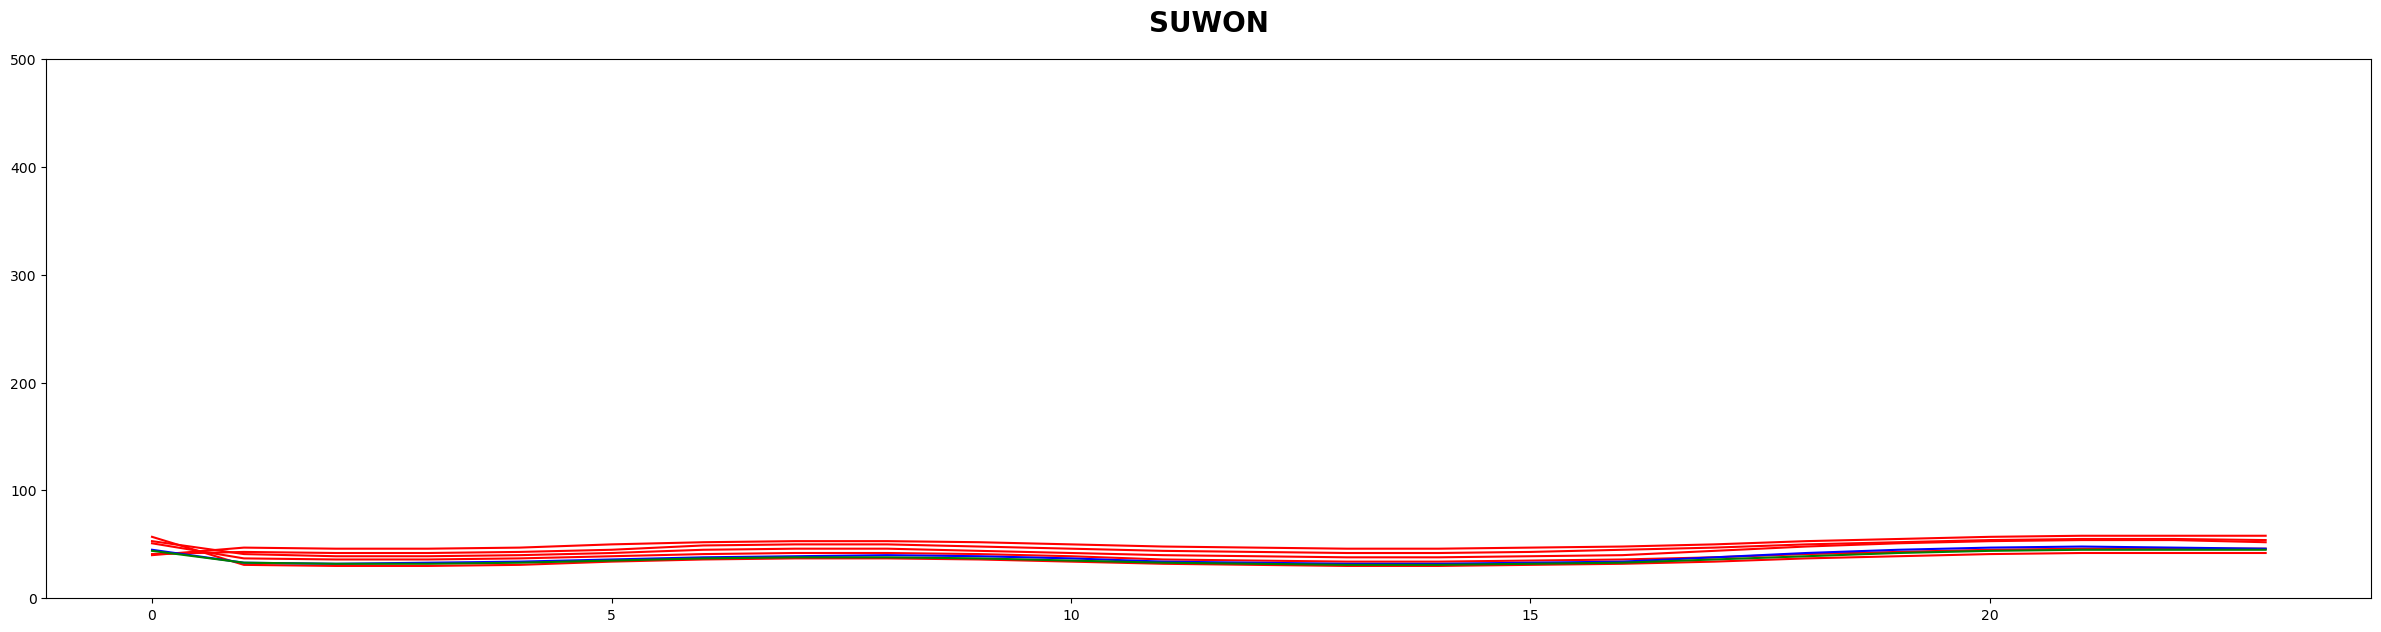

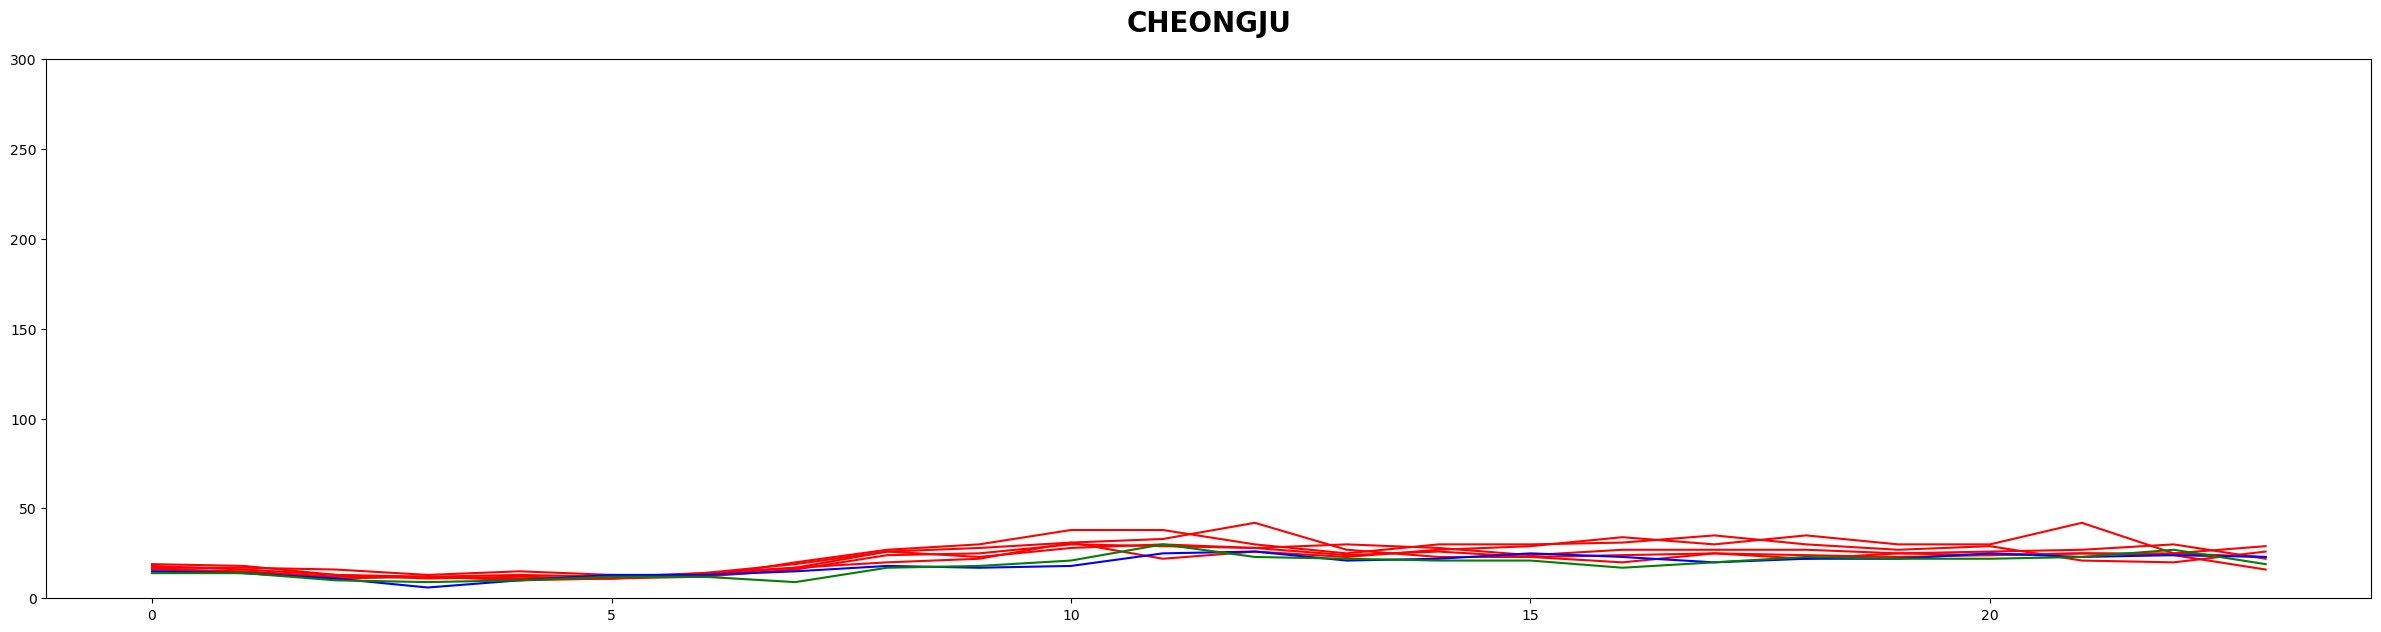

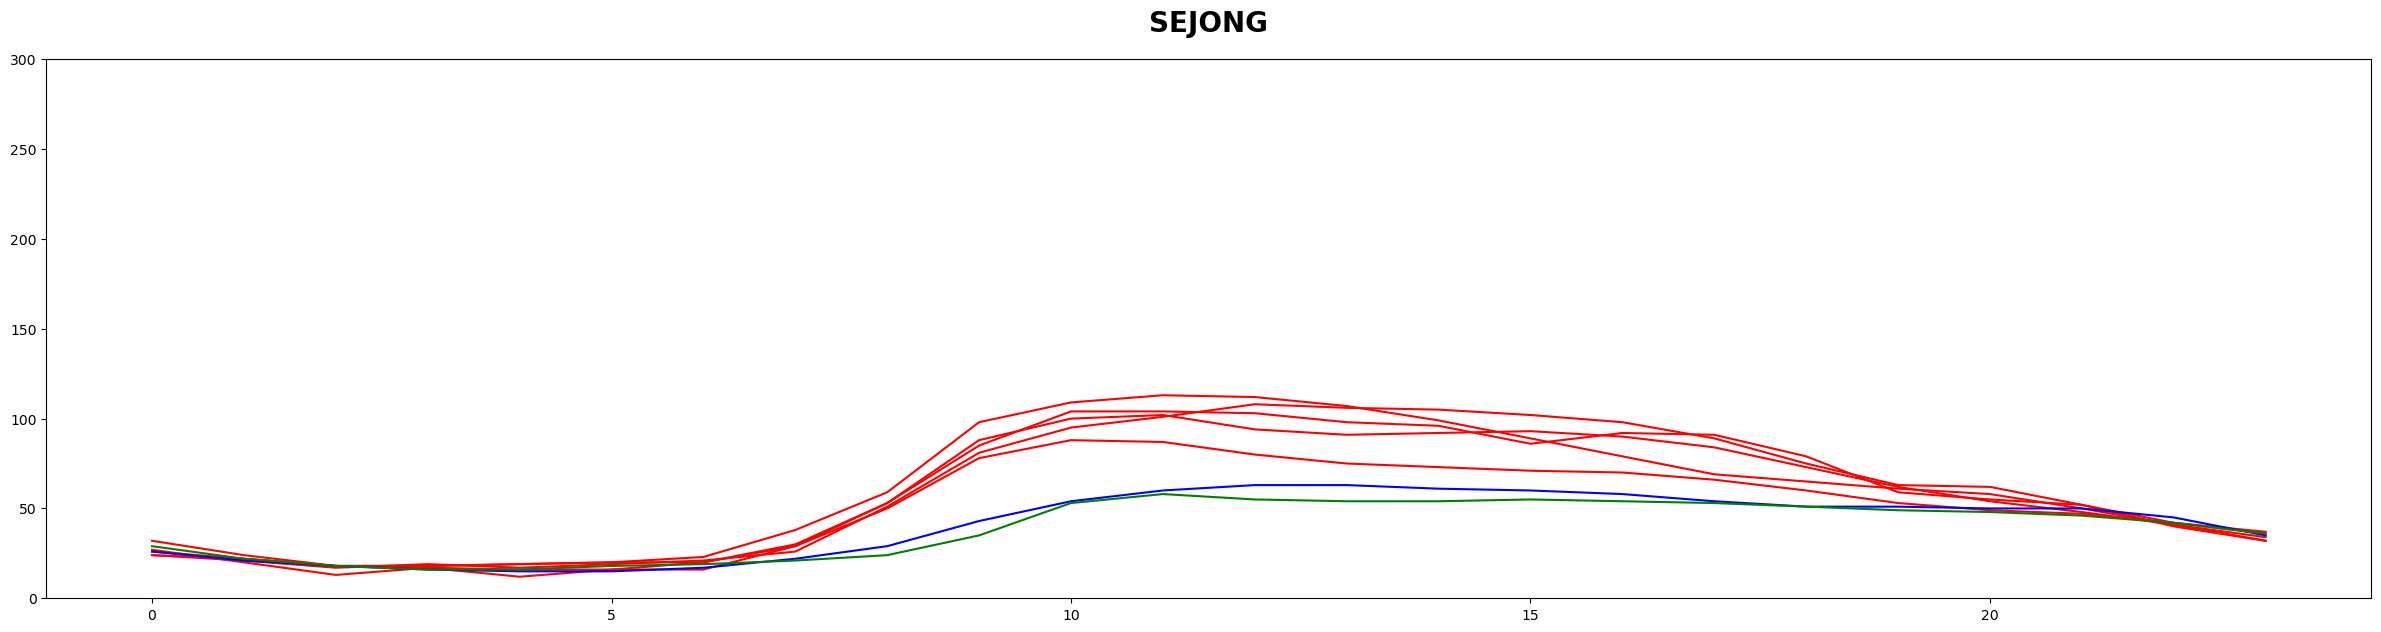

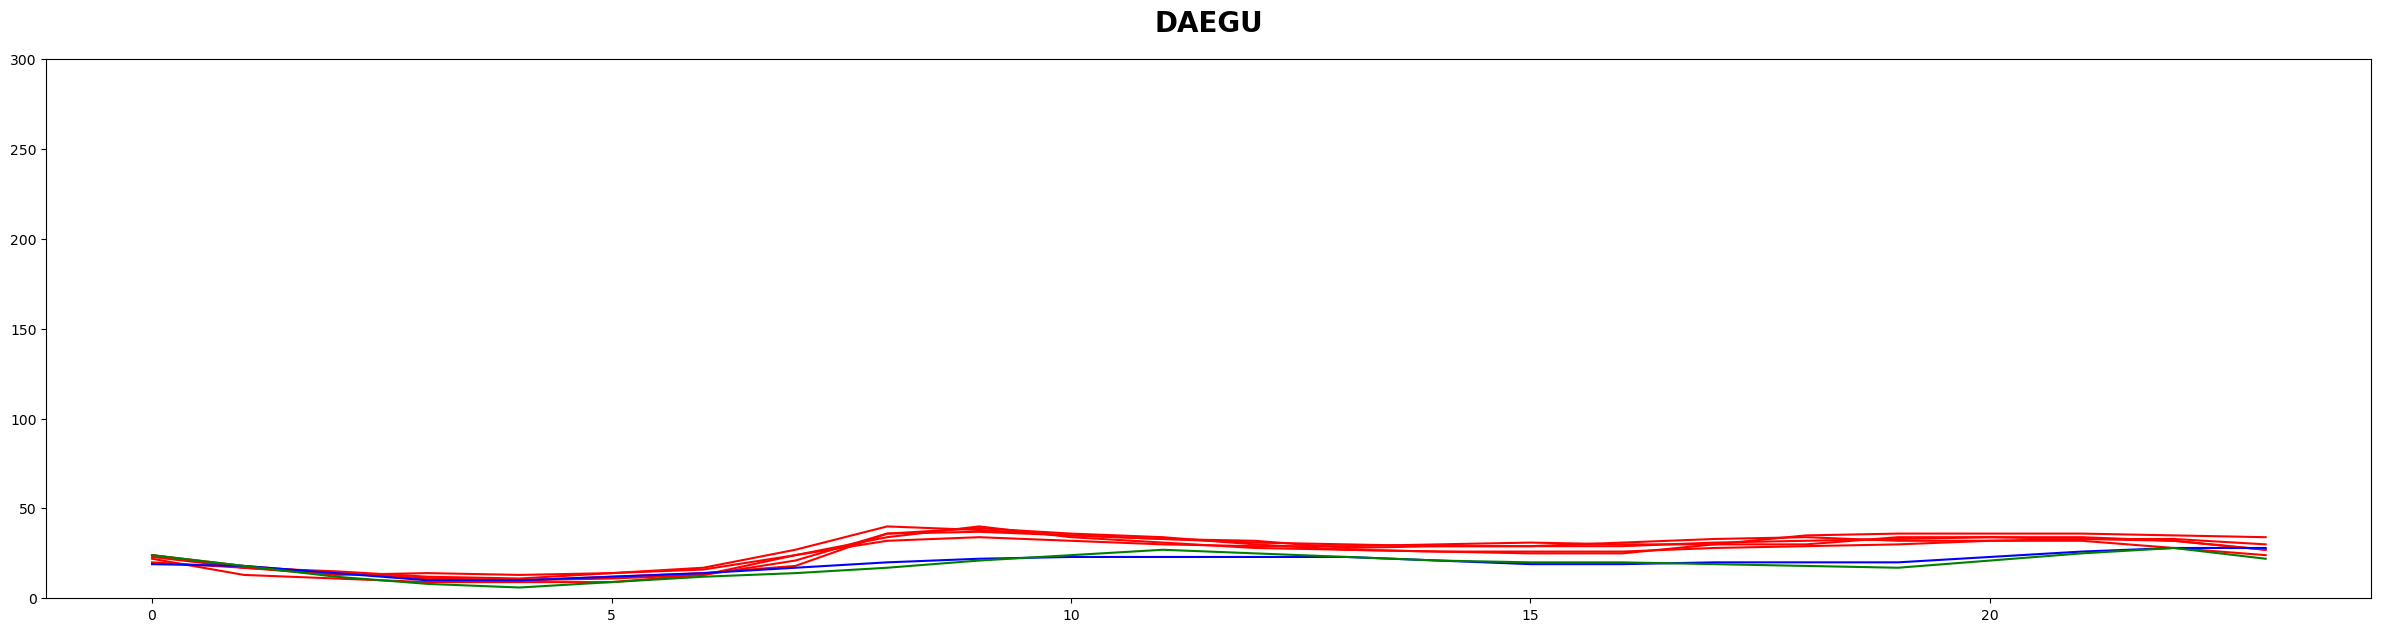

In [243]:
# list_region = ['PAJU', 'GOYANG', 'SAMSONG', 'JOONGANG'
#                , 'KANGNAM'
#                , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN', 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
#                , 'KIMHAE', 'DAEGU', 'YANGSAN'
#                , 'GWANGJU_JEONNAM']
list_region = ['PAJU', 'GOYANG'
               , 'KANGNAM'
               , 'PANGYO', 'BUNDANG', 'SUWON', 'CHEONGJU', 'SEJONG'
               , 'DAEGU']

## 각 지역별 에너지 사용량 범위
dict_max_usage = {'PAJU' : 200
                  , 'GOYANG' : 1000
                  , 'SAMSONG' : 200
                  , 'JOONGANG' : 400
                  , 'KANGNAM' : 1000
                  , 'PANGYO' : 200
                  , 'BUNDANG' : 500
                  , 'YONGIN' : 700
                  , 'GWANGGYO' : 200
                  , 'SUWON' : 500
                  , 'HWASUNG' : 300
                  , 'DONGTAN' : 300
                  , 'PYONGTAEK' : 200
                  , 'CHEONGJU' : 300
                  , 'SEJONG' : 300
                  , 'KIMHAE' : 200
                  , 'DAEGU' : 300
                  , 'YANGSAN' : 200
                  , 'GWANGJU_JEONNAM' : 100
                 }

year_tar = 2020
# month_tar = 12
## [미사용] 날짜 범위
# day_start = 23
# day_end = 29
## 주차 범위
str_week = '33'
str_yearweek = str(year_tar) + '-' + str(str_week)

for str_reg in list_region:
    col_tar = str_reg

    ## [미사용] 년도별
    # df_kdhc_heat_year = df_kdhc_heat[df_kdhc_heat['YEAR'] == year_tar]

    ## [미사용] 월별
    # df_kdhc_heat_month = df_kdhc_heat_year[df_kdhc_heat_year['MONTH'] == month_tar]

    # df_dt = pd.DataFrame()
    # int_dt_start = dt.datetime(year_tar, month_tar, day_start, 0, 0, 0)
    # int_dt_end = dt.datetime(year_tar, month_tar, day_end, 23, 0, 0)
    # df_dt = create_df_dt(df_dt, "METER_DATE", int_dt_start, int_dt_end, '1H')
    ## [미사용] 월별

    ## 주별
    df_kdhc_heat_week = df_kdhc_heat[df_kdhc_heat['WEEK'] == str_yearweek]

    date_tmp = pd.to_datetime(df_kdhc_heat_week['METER_DATE'])

    df_dt = pd.DataFrame()
    int_dt_start = date_tmp.min()
    int_dt_end = date_tmp.max()
    # print(int_dt_start, ' / ', int_dt_end)
    df_dt = create_df_dt(df_dt, "METER_DATE", int_dt_start, int_dt_end, '1H')
    ## [미사용] 주별

    # df_kdhc_heat_month.head(30)
    # df_dt
    df_kdhc_heat_week['METER_DATE'] = pd.to_datetime(df_kdhc_heat_week['METER_DATE'])
    df_kdhc_heat_week = pd.merge(df_dt, df_kdhc_heat_week
                                , how = 'left', on = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'code_day_of_the_week', 'HOUR'])



    range_date = df_kdhc_heat_week['METER_DATE']
    range_hour = range(0, 23 + 1)

    list_wod = range(0, 6 +1)

    df_kdhc_heat_week_00 = df_kdhc_heat_week[df_kdhc_heat_week['code_day_of_the_week'] == 0]
    df_kdhc_heat_week_01 = df_kdhc_heat_week[df_kdhc_heat_week['code_day_of_the_week'] == 1]
    df_kdhc_heat_week_02 = df_kdhc_heat_week[df_kdhc_heat_week['code_day_of_the_week'] == 2]
    df_kdhc_heat_week_03 = df_kdhc_heat_week[df_kdhc_heat_week['code_day_of_the_week'] == 3]
    df_kdhc_heat_week_04 = df_kdhc_heat_week[df_kdhc_heat_week['code_day_of_the_week'] == 4]
    df_kdhc_heat_week_05 = df_kdhc_heat_week[df_kdhc_heat_week['code_day_of_the_week'] == 5]
    df_kdhc_heat_week_06 = df_kdhc_heat_week[df_kdhc_heat_week['code_day_of_the_week'] == 6]

    ## 시각화
    fig, ax1 = plt.subplots(figsize=(30, 7))
    title_font = {'fontsize': 20, 'fontweight': 'bold'}
    plt.ylim([0, dict_max_usage[str_reg]])

    plt.title(col_tar, fontdict=title_font, loc='center', pad = 20)

    c_wd = 'red' ## 평일
    c_wd_rest = 'darkviolet' ## 주말X 휴일
    c_we_sat = 'blue' ## 토
    c_we_sun = 'green' ## 일
    ax1.plot(range_hour, df_kdhc_heat_week_00[col_tar], color = c_wd)
    ax1.plot(range_hour, df_kdhc_heat_week_01[col_tar], color = c_wd)
    ax1.plot(range_hour, df_kdhc_heat_week_02[col_tar], color = c_wd)
    # ax1.plot(range_hour, df_kdhc_heat_week_02[col_tar], color = c_wd_rest)
    ax1.plot(range_hour, df_kdhc_heat_week_03[col_tar], color = c_wd)
    ax1.plot(range_hour, df_kdhc_heat_week_04[col_tar], color = c_wd)
    ax1.plot(range_hour, df_kdhc_heat_week_05[col_tar], color = c_we_sat)
    ax1.plot(range_hour, df_kdhc_heat_week_06[col_tar], color = c_we_sun)
    print('▶ ')
    print('Region / WOD / Sum / Mean')
    print(col_tar, ' / Mon ', ' / ', df_kdhc_heat_week_00[col_tar].sum(), ' / ', df_kdhc_heat_week_00[col_tar].mean())
    print(col_tar, ' / Tue ', ' / ', df_kdhc_heat_week_01[col_tar].sum(), ' / ', df_kdhc_heat_week_01[col_tar].mean())
    print(col_tar, ' / Wed ', ' / ', df_kdhc_heat_week_02[col_tar].sum(), ' / ', df_kdhc_heat_week_02[col_tar].mean())
    print(col_tar, ' / Thr ', ' / ', df_kdhc_heat_week_03[col_tar].sum(), ' / ', df_kdhc_heat_week_03[col_tar].mean())
    print(col_tar, ' / Fri ', ' / ', df_kdhc_heat_week_04[col_tar].sum(), ' / ', df_kdhc_heat_week_04[col_tar].mean())
    print(col_tar, ' / Sat ', ' / ', df_kdhc_heat_week_05[col_tar].sum(), ' / ', df_kdhc_heat_week_05[col_tar].mean())
    print(col_tar, ' / Sun ', ' / ', df_kdhc_heat_week_06[col_tar].sum(), ' / ', df_kdhc_heat_week_06[col_tar].mean())
print(int_dt_start, ' / ', int_dt_end)